In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import os, sys, time, subprocess, h5py, argparse, logging
import numpy as np
from os.path import join as oj
sys.path.append('scat_tf')
from scat_tf import scattering
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 6)

# make scat

In [100]:
J = 2 # spatial scale of filter
L = 8 # number of angular orientations
M, N = 32, 32 # dimensions
scat = scattering.Scattering(M=M, N=N, J=J, L=L) 

# make scat_comp
num_channels = 1 # grayscale or color input
placeholder = tf.placeholder(tf.float32, (1, num_channels, M, N)) # requires NCHW format (cuDNN default - tf is NHWC)
scat_comp = scat(placeholder)
print("J", J, "L", L, "M", M, "N", N, 'input', placeholder.shape, 'output', scat_comp.shape)
print('expected num filts', int(num_channels * (1 + J* L + J * (J-1) * L * L /2)))

J 2 L 8 M 32 N 32 input (1, 1, 32, 32) output (1, 81, 8, 8)
expected num filts 81


# max activation

In [101]:
def visstd(a, s=0.1): # normalize the image range
    return s * (a - a.mean()) / max(a.std(), 1e-4) + 0.5

def get_filt(scat_comp, placeholder, filt_num, step = 250, step_decay = 1, num_iters = 40):
    # set up tf vars
    t_score = tf.reduce_mean(scat_comp[0, filt_num, 4, 4]) # objective
    t_grad = tf.gradients(t_score, placeholder)[0]         # gradient
    im_noise = np.random.uniform(size=(M, N, num_channels)) * 0.01
    im_tf = np.expand_dims(np.transpose(im_noise, (2, 0, 1)), 0)
#     print('shapes', im_noise.shape, im_tf.shape, im_noise.dtype)

    # maximally activate
    for i in range(num_iters):
        g, score = sess.run([t_grad, t_score], {placeholder: im_tf})
#         g /= g.std() + 1e-8 # normalizing the gradient, so the same step size should work for different things        
        im_tf += g * step
        step *= step_decay
#         if i % 10 == 0:
    im_out = np.transpose(np.array(im_tf)[0, 0], (1, 0)) # get np array MxN
#             show(im_out)
#             plt.show()
    return visstd(im_out)

In [49]:
# initialize
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
def show(x):
    plt.imshow(x, interpolation='None', cmap='gray')
    plt.axis('off')

In [ ]:
# get filts
num_filts = int(scat_comp.shape[1])
filts = np.empty(shape=(num_filts, M, N)) # divide by number of colors
# with tf.device("/cpu:0"):
# for filt_num in tqdm(range(num_filts)):
for filt_num in tqdm(range(num_filts)):
    filts[filt_num] = get_filt(scat_comp, placeholder, filt_num)
#     show(filts[filt_num])
#     plt.show()
    
# save filts
out_file = '/scratch/users/vision/chandan/out/scat/' + '_'.join(['filts', 'J='+str(J), 'L='+str(L), 
                                                                'M='+str(M), 'N='+str(N)])
np.save(out_file, filts)

  0%|          | 0/81 [00:00<?, ?it/s]

shapes (32, 32, 1) (1, 1, 32, 32) float64


  1%|          | 1/81 [00:39<53:00, 39.75s/it]

shapes (32, 32, 1) (1, 1, 32, 32) float64


  2%|▏         | 2/81 [01:19<52:18, 39.72s/it]

shapes (32, 32, 1) (1, 1, 32, 32) float64


  4%|▎         | 3/81 [01:59<51:44, 39.80s/it]

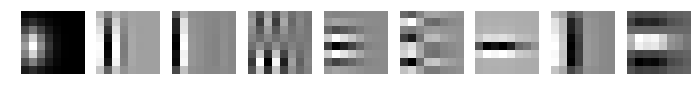

In [83]:
# show filts
plt.figure(figsize=(12, 5))
num_cols = 8
num_rows = int(num_filts / num_cols)

for filt_num in range(num_filts):
    plt.subplot(num_rows, num_cols, filt_num + 1)
    show(filts[filt_num])
plt.show()